## Подключаем все необходимые библиотеки

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

np.random.seed(123)

## Загрузка данных

Читаем тренировочный и тестовый датасеты.

In [2]:
input_train = pd.read_csv('data/train.csv')
input_test = pd.read_csv('data/test.csv')

print(f"Размер train: {input_train.shape}")
print(f"Размер test: {input_test.shape}")
input_train.head()

Размер train: (11017, 35)
Размер test: (5000, 35)


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,31.347091


## Очистка данных

Удаляем пропуски в целевой переменной, экстремальные выбросы и дубликаты.

In [ ]:
input_train = input_train.dropna(subset=['RiskScore'])

# Убираем экстремальные выбросы по целевой переменной
input_train = input_train[(input_train['RiskScore'] > -100000) & (input_train['RiskScore'] < 100000)]

# Удаляем дубликаты
input_train = input_train.drop_duplicates()

q_min = input_train['RiskScore'].quantile(0.001)
q_max = input_train['RiskScore'].quantile(0.999)
input_train = input_train[(input_train['RiskScore'] >= q_min) & (input_train['RiskScore'] <= q_max)]

print(f"Размер после очистки: {input_train.shape}")

Размер после очистки: (9768, 35)


## Распределение целевой переменной

Посмотрим на гистограмму RiskScore после очистки.

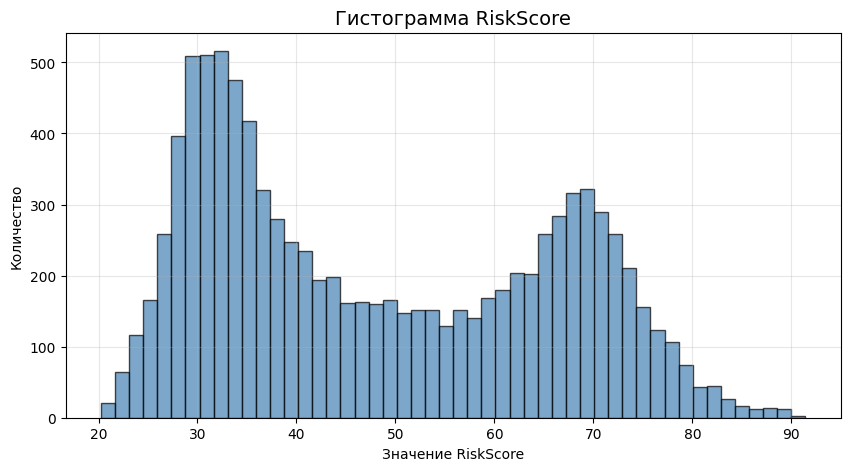

In [4]:
plt.figure(figsize=(10, 5))
plt.hist(input_train['RiskScore'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.title('Гистограмма RiskScore', fontsize=14)
plt.xlabel('Значение RiskScore')
plt.ylabel('Количество')
plt.grid(alpha=0.3)
plt.show()

## Подготовка признаков

Выделяем целевую переменную и формируем матрицы признаков.

In [ ]:
response_var = input_train['RiskScore'].copy()

input_features_train = input_train.drop(['ApplicationDate', 'RiskScore'], axis=1, errors='ignore')
input_features_test = input_test.drop(['ID', 'ApplicationDate'], axis=1, errors='ignore')

print(f"Признаков в train: {input_features_train.shape[1]}")
print(f"Признаков в test: {input_features_test.shape[1]}")

Признаков в train: 33
Признаков в test: 33


## Обработка категориальных переменных

Применяем one-hot encoding к категориальным признакам.

In [ ]:
cat_vars = input_features_train.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальных переменных: {len(cat_vars)}")

if cat_vars:
    input_features_train = pd.get_dummies(input_features_train, columns=cat_vars, drop_first=True)
    input_features_test = pd.get_dummies(input_features_test, columns=cat_vars, drop_first=True)
    
    # Выравниваем колонки между train и test
    cols_only_train = set(input_features_train.columns) - set(input_features_test.columns)
    for col_name in cols_only_train:
        input_features_test[col_name] = 0
    cols_only_test = set(input_features_test.columns) - set(input_features_train.columns)
    input_features_test.drop(columns=cols_only_test, inplace=True)
    
    input_features_test = input_features_test[input_features_train.columns]

print(f"Признаков после encoding: {input_features_train.shape[1]}")

Категориальных переменных: 5
Признаков после encoding: 44


## Импьютация и клиппинг выбросов

Заполняем пропуски медианой и обрезаем выбросы по 2-98 перцентилям.

In [7]:
for var in input_features_train.columns:
    # Заполняем пропуски медианой
    if input_features_train[var].isna().any():
        med_fill = input_features_train[var].median()
        input_features_train[var] = input_features_train[var].fillna(med_fill)
        input_features_test[var] = input_features_test[var].fillna(med_fill)
    
    # Клиппинг выбросов для числовых признаков
    if input_features_train[var].dtype in ['float64', 'int64']:
        p_min = input_features_train[var].quantile(0.02)
        p_max = input_features_train[var].quantile(0.98)
        input_features_train[var] = input_features_train[var].clip(p_min, p_max)
        input_features_test[var] = input_features_test[var].clip(p_min, p_max)

print("Импьютация и клиппинг завершены!")

Импьютация и клиппинг завершены!


## Feature Engineering

Создаём новые признаки: полиномиальные, логарифмические, взаимодействия и т.д.

In [8]:
# Хранилище для новых признаков
additions_train = []
additions_test = []
add_names = []

# Ранжируем признаки по корреляции с целевой переменной
var_corrs = {var: abs(input_features_train[var].corr(response_var)) for var in input_features_train.columns}
sorted_vars = sorted(var_corrs.items(), key=lambda kv: kv[1], reverse=True)

# Выбираем топ признаков для разных преобразований
top20 = [v for v, _ in sorted_vars[:20]]
top15 = [v for v, _ in sorted_vars[:15]]
top12 = [v for v, _ in sorted_vars[:12]]
top10 = [v for v, _ in sorted_vars[:10]]
top5 = [v for v, _ in sorted_vars[:5]]
top4 = [v for v, _ in sorted_vars[:4]]

print(f"Топ-5 признаков по корреляции: {top5}")

Топ-5 признаков по корреляции: ['MonthlyIncome', 'AnnualIncome', 'CreditScore', 'InterestRate', 'BaseInterestRate']


### Визуализация топ признаков по корреляции

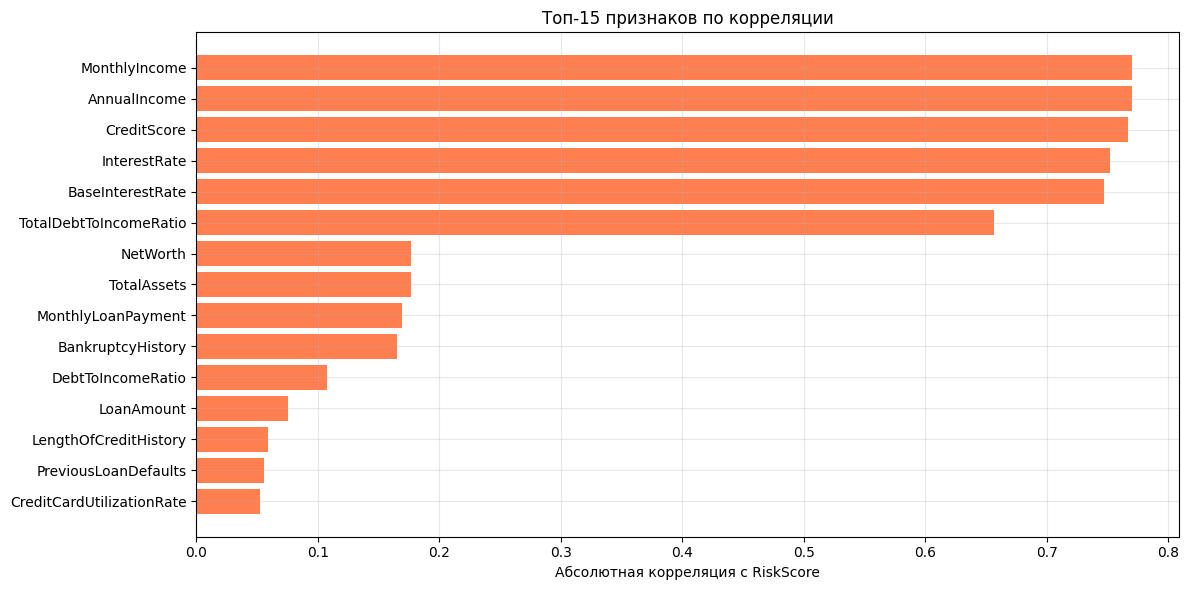

In [9]:
plt.figure(figsize=(12, 6))
top_corrs = sorted_vars[:15]
names = [x[0] for x in top_corrs]
values = [x[1] for x in top_corrs]
plt.barh(range(len(names)), values, color='coral')
plt.yticks(range(len(names)), names)
plt.xlabel('Абсолютная корреляция с RiskScore')
plt.title('Топ-15 признаков по корреляции')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Полиномиальные признаки

Создаём квадраты, кубы и 4-е степени для топовых признаков.

In [10]:
# Квадраты для топ-20
for v in top20:
    additions_train.append(input_features_train[v] ** 2)
    additions_test.append(input_features_test[v] ** 2)
    add_names.append(f'{v}_sqr')

# Кубы для топ-15
for v in top15:
    additions_train.append(input_features_train[v] ** 3)
    additions_test.append(input_features_test[v] ** 3)
    add_names.append(f'{v}_cube')

# 4-я степень для топ-4
for v in top4:
    additions_train.append(input_features_train[v] ** 4)
    additions_test.append(input_features_test[v] ** 4)
    add_names.append(f'{v}_pow4')

print(f"Добавлено полиномиальных признаков: {len(add_names)}")

Добавлено полиномиальных признаков: 39


### Взаимодействия признаков

Создаём попарные и тройные произведения топовых признаков.

In [11]:
# Попарные произведения для топ-12
for idx1 in range(len(top12)):
    for idx2 in range(idx1 + 1, len(top12)):
        v1, v2 = top12[idx1], top12[idx2]
        additions_train.append(input_features_train[v1] * input_features_train[v2])
        additions_test.append(input_features_test[v1] * input_features_test[v2])
        add_names.append(f'{v1}_mul_{v2}')

# Тройные произведения для топ-4
for i in range(len(top4)):
    for j in range(i+1, len(top4)):
        for k in range(j+1, len(top4)):
            v1, v2, v3 = top4[i], top4[j], top4[k]
            additions_train.append(input_features_train[v1] * input_features_train[v2] * input_features_train[v3])
            additions_test.append(input_features_test[v1] * input_features_test[v2] * input_features_test[v3])
            add_names.append(f'{v1}_mul_{v2}_mul_{v3}')

print(f"Всего признаков после взаимодействий: {len(add_names)}")

Всего признаков после взаимодействий: 109


### Логарифмические и корневые преобразования

In [12]:
# Логарифм для финансовых признаков
key_finance = ['AnnualIncome', 'MonthlyIncome', 'LoanAmount', 'TotalAssets', 'NetWorth', 
               'CreditScore', 'SavingsAccountBalance', 'CheckingAccountBalance']
for v in key_finance:
    if v in input_features_train.columns:
        additions_train.append(np.log1p(np.maximum(input_features_train[v], 0)))
        additions_test.append(np.log1p(np.maximum(input_features_test[v], 0)))
        add_names.append(f'{v}_ln')

# Квадратный корень для топ-15
for v in top15:
    additions_train.append(np.sqrt(np.abs(input_features_train[v])))
    additions_test.append(np.sqrt(np.abs(input_features_test[v])))
    add_names.append(f'{v}_sqrt')

# Обратные значения для топ-5
for v in top5:
    additions_train.append(1 / (np.abs(input_features_train[v]) + 1))
    additions_test.append(1 / (np.abs(input_features_test[v]) + 1))
    add_names.append(f'{v}_inv')

print(f"Всего признаков после преобразований: {len(add_names)}")

Всего признаков после преобразований: 137


### Финансовые соотношения

Создаём осмысленные соотношения между финансовыми показателями.

In [13]:
# Соотношение годового и месячного дохода
if 'AnnualIncome' in input_features_train.columns and 'MonthlyIncome' in input_features_train.columns:
    additions_train.append(input_features_train['AnnualIncome'] / (input_features_train['MonthlyIncome'] * 12 + 1))
    additions_test.append(input_features_test['AnnualIncome'] / (input_features_test['MonthlyIncome'] * 12 + 1))
    add_names.append('inc_consist')

# Кредитный скор относительно возраста
if 'CreditScore' in input_features_train.columns and 'Age' in input_features_train.columns:
    additions_train.append(input_features_train['CreditScore'] / (input_features_train['Age'] + 1))
    additions_test.append(input_features_test['CreditScore'] / (input_features_test['Age'] + 1))
    add_names.append('cred_age')

# Сумма кредита относительно дохода
if 'LoanAmount' in input_features_train.columns and 'AnnualIncome' in input_features_train.columns:
    additions_train.append(input_features_train['LoanAmount'] / (input_features_train['AnnualIncome'] + 1))
    additions_test.append(input_features_test['LoanAmount'] / (input_features_test['AnnualIncome'] + 1))
    add_names.append('loan_inc')

# Сумма кредита относительно чистой стоимости
if 'LoanAmount' in input_features_train.columns and 'NetWorth' in input_features_train.columns:
    additions_train.append(input_features_train['LoanAmount'] / (input_features_train['NetWorth'] + 1))
    additions_test.append(input_features_test['LoanAmount'] / (input_features_test['NetWorth'] + 1))
    add_names.append('loan_net')

# Соотношение долгов к активам
if 'TotalLiabilities' in input_features_train.columns and 'TotalAssets' in input_features_train.columns:
    additions_train.append(input_features_train['TotalLiabilities'] / (input_features_train['TotalAssets'] + 1))
    additions_test.append(input_features_test['TotalLiabilities'] / (input_features_test['TotalAssets'] + 1))
    add_names.append('debt_asset')

# Сбережения относительно месячного дохода
if 'SavingsAccountBalance' in input_features_train.columns and 'MonthlyIncome' in input_features_train.columns:
    additions_train.append(input_features_train['SavingsAccountBalance'] / (input_features_train['MonthlyIncome'] + 1))
    additions_test.append(input_features_test['SavingsAccountBalance'] / (input_features_test['MonthlyIncome'] + 1))
    add_names.append('savings_inc')

print(f"Добавлено финансовых соотношений")

Добавлено финансовых соотношений


### Бинаризация возраста

Разбиваем возраст на категории: молодые, средний возраст, пожилые.

In [ ]:
bins = [0, 30, 50, 100]
labels = [0, 1, 2]  # 0 =молодые, 1 = средний возраст, 2 = пожилые
age_binned_train = pd.cut(input_features_train['Age'], bins=bins, labels=labels, ordered=True)
age_binned_test = pd.cut(input_features_test['Age'], bins=bins, labels=labels, ordered=True)
additions_train.append(pd.Series(age_binned_train).astype(float))
additions_test.append(pd.Series(age_binned_test).astype(float))
add_names.append('age_binned')

print(f"Итого новых признаков: {len(add_names)}")

Итого новых признаков: 144


## Объединение всех признаков

In [15]:
# Собираем все новые признаки в DataFrame
add_df_train = pd.concat([pd.Series(data, name=n) for data, n in zip(additions_train, add_names)], axis=1)
add_df_test = pd.concat([pd.Series(data, name=n) for data, n in zip(additions_test, add_names)], axis=1)

# Объединяем с исходными признаками
input_features_train = pd.concat([input_features_train.reset_index(drop=True), add_df_train.reset_index(drop=True)], axis=1)
input_features_test = pd.concat([input_features_test.reset_index(drop=True), add_df_test.reset_index(drop=True)], axis=1)

print(f"Итоговое количество признаков: {input_features_train.shape[1]}")

Итоговое количество признаков: 188


## Обработка бесконечных значений и пропусков

In [ ]:
input_features_train = input_features_train.replace([np.inf, -np.inf], np.nan)
input_features_test = input_features_test.replace([np.inf, -np.inf], np.nan)

for var in input_features_train.columns:
    if input_features_train[var].isna().sum() > 0:
        med_val = input_features_train[var].median()
        fill_val = 0 if np.isnan(med_val) else med_val
        input_features_train[var].fillna(fill_val, inplace=True)
        input_features_test[var].fillna(fill_val, inplace=True)

print("Обработка пропусков завершена!")

Обработка пропусков завершена!


## Удаление мультиколлинеарных признаков

Удаляем признаки с корреляцией выше 0.995 между собой.

In [ ]:
corr_table = input_features_train.corr()
remove_set = set()

for row in range(corr_table.shape[0]):
    for col in range(row + 1, corr_table.shape[1]):
        if abs(corr_table.iloc[row, col]) > 0.995:
            var1, var2 = corr_table.columns[row], corr_table.columns[col]
            corr1 = abs(input_features_train[var1].corr(response_var))
            corr2 = abs(input_features_train[var2].corr(response_var))
            remove_set.add(var2 if corr1 > corr2 else var1)

if remove_set:
    print(f"Удаляем {len(remove_set)} мультиколлинеарных признаков")
    input_features_train.drop(columns=remove_set, inplace=True)
    input_features_test.drop(columns=remove_set, inplace=True)

print(f"Признаков после удаления: {input_features_train.shape[1]}")

Удаляем 37 мультиколлинеарных признаков
Признаков после удаления: 151


## Стандартизация признаков

In [18]:
scaler_obj = StandardScaler()
input_features_train_scaled = scaler_obj.fit_transform(input_features_train)
input_features_test_scaled = scaler_obj.transform(input_features_test)

print("Стандартизация завершена!")

Стандартизация завершена!


## Разделение на train/validation

In [19]:
train_feats, val_feats, train_resp, val_resp = train_test_split(
    input_features_train_scaled, response_var, test_size=0.2, random_state=123
)

print(f"Train: {train_feats.shape}")
print(f"Validation: {val_feats.shape}")

Train: (7814, 151)
Validation: (1954, 151)


## Обучение модели линейной регрессии

In [20]:
reg_model = LinearRegression()
reg_model.fit(train_feats, train_resp)

print("Модель обучена!")

Модель обучена!


## Оценка качества на валидации

In [21]:
val_predictions = reg_model.predict(val_feats)
assess_mse = mean_squared_error(val_resp, val_predictions)
assess_r2 = r2_score(val_resp, val_predictions)

print(f"MSE на валидации: {assess_mse:.2f}")
print(f"R² на валидации: {assess_r2*100:.1f}%")

MSE на валидации: 24.20
R² на валидации: 91.9%


### Визуализация предсказаний vs реальных значений

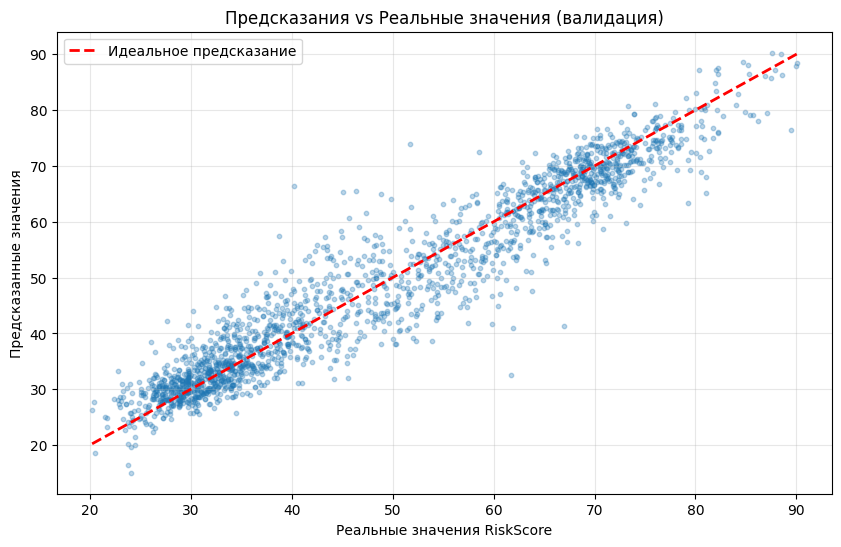

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(val_resp, val_predictions, alpha=0.3, s=10)
plt.plot([val_resp.min(), val_resp.max()], [val_resp.min(), val_resp.max()], 'r--', lw=2, label='Идеальное предсказание')
plt.xlabel('Реальные значения RiskScore')
plt.ylabel('Предсказанные значения')
plt.title('Предсказания vs Реальные значения (валидация)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Распределение ошибок

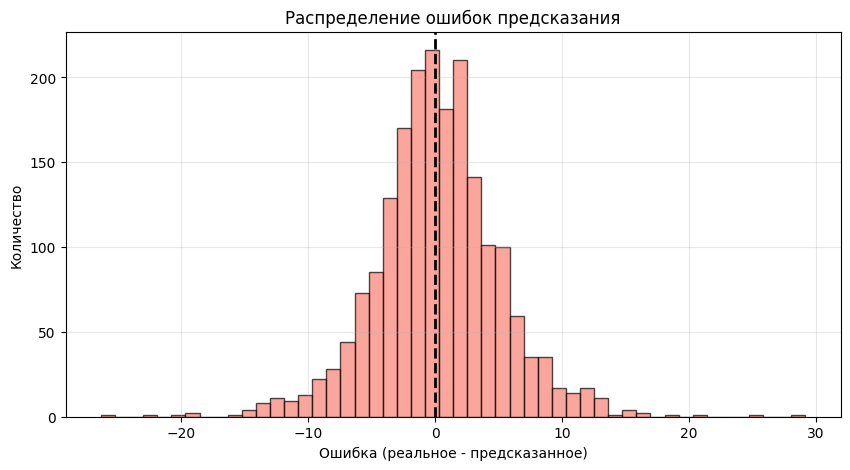

In [23]:
errors = val_resp.values - val_predictions
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='salmon')
plt.axvline(x=0, color='black', linestyle='--', lw=2)
plt.title('Распределение ошибок предсказания')
plt.xlabel('Ошибка (реальное - предсказанное)')
plt.ylabel('Количество')
plt.grid(alpha=0.3)
plt.show()

## Финальное обучение и предсказание на тесте

In [24]:
# Переобучаем на всех данных
reg_model.fit(input_features_train_scaled, response_var)

# Предсказываем на тестовой выборке
test_predictions = reg_model.predict(input_features_test_scaled)

print(f"Предсказано {len(test_predictions)} значений")

Предсказано 5000 значений


## Сохранение результатов

In [25]:
results_df = pd.DataFrame({
    'ID': input_test['ID'],
    'RiskScore': test_predictions
})

results_df.to_csv('submission.csv', index=False)
print("Результаты сохранены в submission.csv")
results_df.head()

Результаты сохранены в submission.csv


,ID,RiskScore
0,0,33.420016
1,1,54.173683
2,2,31.227954
3,3,35.084104
4,4,33.535177


## Итоговые результаты

In [26]:
print("=" * 50)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("=" * 50)
print(f"Количество записей: {len(response_var)}")
print(f"Количество признаков: {input_features_train.shape[1]}")
print(f"MSE на валидации: {assess_mse:.2f}")
print(f"R² на валидации: {assess_r2*100:.1f}%")
print("=" * 50)

ИТОГОВЫЕ РЕЗУЛЬТАТЫ
Количество записей: 9768
Количество признаков: 151
MSE на валидации: 24.20
R² на валидации: 91.9%
